# EMD-ARIMA & ARIMA 모델을 적용한 SOH 예측

### 모듈 불러오기

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action = 'ignore')

import statsmodels.api as sm

In [3]:
from PyEMD import EMD,Visualisation, EEMD
from statsmodels.tsa.arima.model import ARIMA
from numpy.linalg import LinAlgError
from pandas import Series

### 데이터 불러오기

사용 데이터는 그룹A의 데이터 배터리 5,6,7,18 

In [6]:
bat_name = os.listdir('./data')

In [7]:
bat_name

['B05_discharge.csv',
 'B06_discharge.csv',
 'B07_discharge.csv',
 'B18_discharge.csv']

In [8]:
data = pd.read_csv('./data/%s'%bat_name[1],engine = 'python') # 5번 배터리 데이터

b005 = pd.read_csv('./data/%s'%bat_name[0],engine = 'python') # 5번 배터리 데이터
b006 = pd.read_csv('./data/%s'%bat_name[1],engine = 'python') # 6번 배터리 데이터
b007 = pd.read_csv('./data/%s'%bat_name[2],engine = 'python') # 7번 배터리 데이터
b018 = pd.read_csv('./data/%s'%bat_name[3],engine = 'python') # 18번 배터리 데이터

canonical_capacity = 2
soh_data = b005['capacity']/canonical_capacity
l = len(b005.columns)
b005.insert(l,'SOH',soh_data)

soh_data = b006['capacity']/canonical_capacity
l = len(b006.columns)
b006.insert(l,'SOH',soh_data)

soh_data = b007['capacity']/canonical_capacity
l = len(b007.columns)
b007.insert(l,'SOH',soh_data)

soh_data = b018['capacity']/canonical_capacity
l = len(b018.columns)
b018.insert(l,'SOH',soh_data)


<h5> 배터리 5 : b005<br><br>
     배터리 6 : b006<br><br>
     배터리 7 : b007<br><br>
     배터리 18 : b018
    
    

## SOH 계산 - column 추가

In [9]:
canonical_capacity = 2
soh_data = data['capacity']/canonical_capacity

l = len(data.columns)
data.insert(l,'SOH',soh_data)

In [10]:
pd.concat([data.head(),data.tail()],axis = 0)

,terminal_voltage,terminal_current,temperature,charge_current,charge_voltage,time,capacity,cycle,SOH
0,4.179800,-0.002366,24.277568,-0.0006,0.000,0.000,2.035338,1,1.017669
1,4.179823,0.000434,24.277073,-0.0006,4.195,16.781,2.035338,1,1.017669
2,3.966528,-2.014242,24.366226,-1.9990,3.070,35.703,2.035338,1,1.017669
3,3.945886,-2.008730,24.515123,-1.9990,3.045,53.781,2.035338,1,1.017669
4,3.930354,-2.013381,24.676053,-1.9990,3.026,71.922,2.035338,1,1.017669
50280,3.689577,-0.001671,32.367946,0.0006,0.000,2781.312,1.185675,168,0.592838
50281,3.690020,-0.001914,32.464485,0.0006,0.000,2791.062,1.185675,168,0.592838
50282,3.690708,-0.002706,32.337187,0.0006,0.000,2800.828,1.185675,168,0.592838
50283,3.691356,-0.002952,32.252598,0.0006,0.000,2810.640,1.185675,168,0.592838
50284,3.691809,-0.003127,32.192324,0.0006,0.000,2820.390,1.185675,168,0.592838


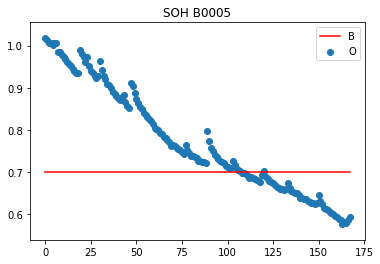

In [11]:
soh_list = data[data['time'] == 0]['SOH']

plt.scatter(range(168),soh_list)
plt.plot(range(168),[0.7 for i in range(168)],color = 'red')
plt.legend('%ssoh'%'BOOO5')
plt.title('SOH B0005')
plt.show()

## Threshold 0.7까지 남은 cycle수 (Remaining Useful Life)와 SOH 예측 목표

### Cycle 단위로 데이터의 분포 확인

In [12]:
times = []
for i in range(1,169):
    times.append(list(data[data['cycle']==i]['time'])[-1])

Text(0.5, 1.0, 'Times of Cycles')

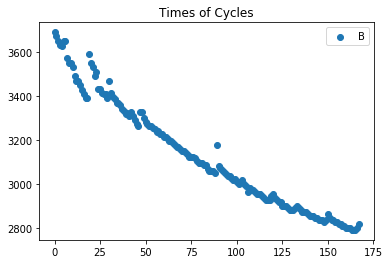

In [13]:
plt.scatter(range(168),times)
plt.legend('B0005 Times')
plt.title('Times of Cycles')

SOH의 변화와 Cycle 관찰 시간의 패턴이 유사함을 보인다. 

**외부요인인 Time에 대한 통제 후 데이터를 다시 관찰하면 다른 패턴을 보일 것이라고 예상할 수 있다.비슷한 패턴이 나온 이유는 capacity 계산 과정 중 시간에 대한 적분이 들어갔기 때문이다. 계산을 통해 변수들의 관계가 종속적인 특징을 갖게 되었다.**

**시간을 예측하기란 굉장히 어렵다. 하지만 여기서의 시간은 방전 시간으로 cycle이 증가함에 따라 시간은 감소하고 결국 SOH의 예측은 방전 시간의 예측으로 연결된다. 따라서 SOH 단일 변수로 배터리의 성능을 예측한 본 논문을 분석할때 외부요인인 시간 통제에 대해서는 무시하고 예측을 진행한다.**

### Model 1. EMD -ARIMA

배터리 - 5

In [14]:
cycles = len(soh_list)

starting_point = 100

In [15]:
## 데이터 선택
soh_list = b005[b005['time'] == 0]['SOH']*100

In [16]:
train = soh_list[:starting_point]
test = soh_list[starting_point:]

In [17]:
emd = EMD()
emd.emd(train.values,max_imf = 4)

array([[ 4.06770691e-01,  3.32242397e-02, -3.54014981e-01,
        -1.93643206e-01, -7.10454466e-02,  1.10565069e-01,
         1.90040703e-01, -1.75536604e-01, -9.85688377e-02,
         3.90395565e-02,  1.93693838e-01, -1.81203596e-01,
        -6.65490404e-02,  1.16124143e-01, -1.13041319e-01,
         1.84649410e-01,  3.05596756e-01,  9.53002506e-04,
        -6.86381384e-01,  8.05165251e-01,  3.97448086e-01,
        -2.12061754e-01, -5.32363681e-01, -2.60029751e-01,
         1.38143209e-01, -8.26640450e-02,  2.01231075e-01,
         1.33205889e-01, -6.80140321e-01, -9.82922733e-01,
         1.06187599e+00, -6.06988992e-02, -3.90472142e-01,
        -5.00190700e-01, -1.87197050e-01,  8.84420277e-02,
        -3.50929625e-02,  6.63889245e-02, -9.98552479e-02,
         9.75010576e-02, -2.73937535e-02, -1.53100011e-01,
         3.13598863e-01,  2.02393498e-01, -3.05741528e-01,
        -8.58906893e-01, -1.30421803e+00,  1.35364304e+00,
         7.03528433e-01, -7.38906352e-02, -4.17749714e-0

In [18]:
imfs, res = emd.get_imfs_and_residue()
print(imfs.shape,res.shape)

(4, 100) (100,)


In [19]:
vis = Visualisation()
t = range(len(train))

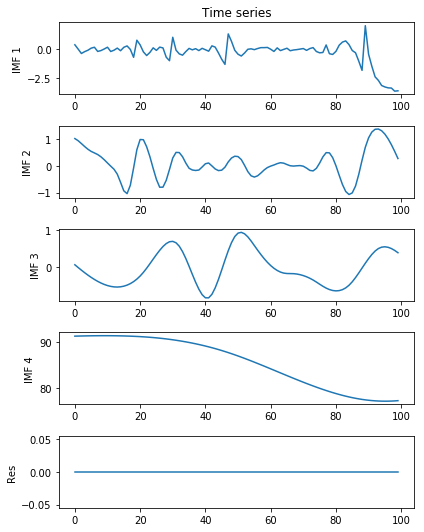

In [20]:
vis.plot_imfs(imfs = imfs, residue = res, t = t, include_residue = True)
vis.show()

신호 분석을 통해 신호의 모양이 분해된 것을 확인

### level - IMF ARIMA model prediction

#### C1

In [21]:
train_set = Series(imfs[0],index=range(starting_point))

In [22]:
mod = sm.tsa.ARIMA(train_set,(2,0,0)).fit()

In [23]:
forecaste_size = cycles-starting_point

fore = mod.forecast(steps = forecaste_size)
#fore = mod.forecast(steps = 30)

In [24]:
c1_result = fore[0]

#### C2

In [25]:
train_set = Series(imfs[1],index=range(starting_point))
mod = sm.tsa.ARIMA(train_set,(2,0,0)).fit()
fore = mod.forecast(steps = forecaste_size)
#fore = mod.forecast(steps = 30)

In [26]:
c2_result = fore[0]

#### C3

In [27]:
train_set = Series(imfs[2],index=range(starting_point))
mod = sm.tsa.ARIMA(train_set,(1,0,0)).fit()
fore = mod.forecast(steps = forecaste_size)
#fore = mod.forecast(steps = 30)

In [28]:
c3_result = fore[0]

#### C4

In [29]:
train_set = Series(imfs[3],index=range(starting_point))
mod = sm.tsa.ARIMA(train_set,(1,0,0)).fit()
fore = mod.forecast(steps = forecaste_size)
#fore = mod.forecast(steps = 30)

In [30]:
c4_result = fore[0]

#### R

In [31]:
train_set = Series(res,index=range(starting_point))
mod = sm.tsa.ARIMA(train_set,(0,1,0)).fit()
fore = mod.forecast(steps = forecaste_size)
#fore = mod.forecast(steps = 30)

In [32]:
r_result = fore[0]

In [33]:
result_data  = c1_result + c2_result + c3_result + r_result + c4_result

In [34]:
emd_result = result_data

In [35]:
#cycles = 130
#forecaste_size = 30

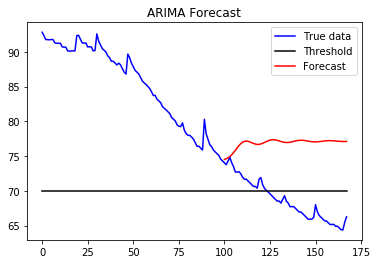

In [36]:
plt.plot(range(cycles),soh_list,color = 'blue')
plt.plot(range(cycles),[70 for i in range(cycles)],color = 'black')
plt.plot(range(starting_point,starting_point+forecaste_size,1),result_data ,color = 'red')
#plt.plot(range(100,130,1),result_data ,color = 'red')
plt.title('ARIMA Forecast')
plt.legend(['True data','Threshold','Forecast'])